# Barrier Options with Control Variates

Some notes:

1. Barrier Options can be priced analytically with the traditional Black Scholes partial differential equation. We assume that the barrier option is being continously monitored, and we adjust the boundary conditions of the PDE to account for the barrier. Doing so willl give us analytical formulas that are very long and complex.

2. The reason why we can price barrier options analytically, but we can't price other path dependent options analytically, such as Asian options, is because the path-dependent nature is not the same. The path dependency of the barrier option is if the value of the stochastic process (the stock price trajectory) hits a constant value, not a time dependent value, or a stochastic value. Meanwhile, Asian options' payoffs are determined by the average value of the stock price on that path. This is entirely random and cannot be modeled as an input that results in an adjustment to boundary conditions or the like.

However, it is possible to price exotics in general, including Asian options, byh extending the process to a higher dimensionality, and then applying the Feyman Kac formula in that higher dimensional space to obtain a Partial Differential Equation. Then you would solve that partial differential equation.

3. If we think about it, an up and out call, as well as a down and out put are both types of barrier options that we really don't want to be long. If we are in the money for a call, we want to be in the money by as much as possible. If doing so causes us to breach a predefined barrier that casues our option to become worthless, that's not good. The same argument can be made for the put.

I'd be curious to see if there are a sellers discount on these barrier options, or a buyer's premium on the down and in put, up and in call.

4. Some information regarding hedging the up and out call. at $S_t = B$, the option price has a discontinuity from being worth $ B - K$ to $0$. Thus, for $t$ near $T$ and $S_t$ just below $B$, the delta and gamma are both large negative values. Therefore, the option seller will need to start shorting shares to hedge the up and out call, and then after expiration the trader would need to buy back the shares. Because the delta is large and negative, the trader would need to take a large short position. Because the gamma is large and negative, the trader would need to make large adjustments to the position. Thus, a large amount of trading would be required.

Therefore, to prevent this, a common industry practice would to be price and hedge the up and out call as if the barrier were at a slightly higher level than B. That way, the regime where delta and gamma are large and negative occurs in the region above the contractual barrier B, and therefore this involved trading is no longer necessary.

References:

https://bookdown.org/maxime_debellefroid/MyBook/barrier-options.html

Shreve, Stochastic calculus for finance, 

Hull, Options, Futures, and other Derivatives.


The payoff of an up and out, continuously monitored barrier call is:

$ V(t, S_t) = \mathbb{E}^\mathbb{Q} \left[ e^{-r(T-t)}\mathbb{I}_{\tau(b)> T}\max(S_T - K, 0) \right | \mathcal{F}_t] $

where $\tau(b) = \inf\{t: S(t) \geq b\}$.

"Inf" in this case refers to infimum, that is the greatest element that is lower or equal to the lowest element of the superset that the quantity in question belongs to. In simple English, $\tau(b)$ refers to the first time the process $S(t)$ is greater than or equal to the barrier. Since this is an up and out call, the indicator function in the payoff means that the first time the process exceeds the barrier occurs after the maturity. That is to say, at and prior to maturity, the barrier is not breached, which we want in order for this option payoff to be worth something.

The simulation is below.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp


# Set seed
np.random.seed(seed=234513)


# GBM parameters
r = 0.02
sigma = 0.2
BM_drift = 0 # = r - sigma^2/2;
S0 = 50

# Generate 10000 sample paths
reps = 10000 # of replications (sample paths)
m = 2**10 # of time points t_i, not including t=0
#Sample from a N(0, 1) with dimension/shape (reps, m)
Z  = sp.norm.rvs(loc = 0, scale = 1, size = (reps, m))
#Add a reps x 1 column to the beginning of the matrix for the t = 0 point
Z = np.concatenate((np.zeros(shape = (reps, 1)), Z), axis = 1)

coef = np.sqrt(1/m) # sqrt(t_i - t_{i-1})
W = np.cumsum(sigma * coef * Z , axis = 1) # cumulative sum across rows (over time)
S = S0*np.exp(W)

# Other parameters
b = 75 # barrier
K = 60 # strike
T = 1 # maturity

# Calculate discounted payoffs

#[maxS, ~] = max(S, [], 2) # maximum for each sample path 
#disc_payoffs = np.exp(-r*T)*(maxS < b).*max(S(:,m+1) - K, zeros(reps, 1));

#compute maximum value attained across every simulation
maxS = np.max(S, axis = 1)
disc_payoffs = np.exp(-r * T) * (maxS < b) * np.maximum(S[:,-1] - K, 0)

# Monte Carlo estimator
price_MC = np.mean(disc_payoffs)
sd_MC = np.std(disc_payoffs)
z_alpha2 = 1.96

CI_MC = [price_MC - z_alpha2*sd_MC/np.sqrt(reps), price_MC + z_alpha2*sd_MC/np.sqrt(reps)]
print(f'Part 0: The Monte Carlo estimator is {price_MC:.4f} with 95 percent CI is [{CI_MC[0]:.4f}, {CI_MC[1]:.4f}]')


Part 0: The Monte Carlo estimator is 0.6390 with 95 percent CI is [0.5985, 0.6796]


## Control Variates

Whenever estimating a random variable on its own, the variance is determined by aspects such as sample size and sampling methodology. When estimating a function of a random variable, the function itself introduces more variance. However, if the behavior of the function is known, then those quantities can be "filtered" out to reduce the variance of the statistic that requires estimation.

In other words, if the estimate contains some known quantities, then any error associated with that known quantity can be removed to the reduce the error of an estimate of the unknown quantity.

Formal definition:

Let $(X_1, Y_1), ... , (X_n, Y_n)$ be i.i.d. outputs from $n$ replications of a simulation. Suppose the goal is to estimate $\mathbb{E}[Y_1]$. The standard Monte Carlo estimator is $\bar{Y} = \frac{Y_1 + Y_2 + ... + Y_{n-1} + Y_{n}}{n}$ and it is unbiased and consistent.

As a quick review, unbiased means the expected value of the estimator ($\bar{Y}$) is equal to the population parameter, i.e. has no offset. Consistent means as the sample size $n$ approaches infinity (if we take the limit), the estimator converges to the population parameter.

Suppose that $\mathbb{E}[X_1]$ is known (and probably easier, less difficult to compute). Then we can define for any fixed constant $\lambda$:

$Y_i(\lambda) = Y_i - \lambda(X_i - \mathbb{E}[X_1])$

We can then define the control variate estimator as

$\bar{Y}(\lambda) = \frac{1}{n} \sum\limits_{i=1}^{n} Y_i(\lambda)$

It can be shown that this estimator is consistent and unbiased. Using the properties of variance, the variance can be expanded as:

$Var(\bar{Y}(\lambda)) = \frac{1}{n} \left[ Var(Y1) - 2\lambda Cov(X_1, Y_1) + \lambda^2 Var(X_1) \right]$

This function is a convex quadratic for $\lambda$. Thus we can take the derivative with respect to $\lambda$ and set it equal to zero to find the global minimum. Doing so yields

$\lambda^{*} = \frac{Cov(X_1, Y_1)}{Var(X_1)}$

This value of lambda minimizes the variance.

More computation will show that the mimimum variance $\sigma^2(\lambda^{*}) = (1 - \rho_{XY}^2)Var(Y_1)$

One last step is that the correlation coefficient itself is typically unknown, so $\lambda^{*}$ needs to be estimated. This can be done across the Monte Carlo replicates, and this technique is referred to as regression sampling. The estimator is:

$\lambda_n = \frac{\sum_{i=1}^{n} (X_i - \bar{X}) (Y_i - \bar{Y})}{\sum_{i=1}^{n}(X_i - \bar{X})^2}$

which if you look closely is simply the ratio of the sample covariance to the sample variance (the $\frac{1}{n-1}$ terms have been ommitted from both the numerator and denominator).

So the question remains, what do we choose as a control variate? As mentioned, it has to be a quantity such that its expectation can be computed. Also, it needs to be correlated to some degree with the statistic we are trying to estimate (the barrier option payoff).

We will examine three candidates

1. The price of the underlying at the time of expiration $S(T)$
2. The discounted payoff of a European call, with the same exact strike, maturity, and dynamics of the underlying, i.e. $e^{-rT}[S(T) - K]^+$
3. An indicator for whether or not the barrier option will be positive: $\mathbb{I}\{ \max_{0\leq t \leq T} S(t) < b , S(T) > K\} $

To further see the results of variance reduction, we will maintain the random seed so we are in effect using common random numbers.

In [15]:

#Estimator a: S(T)
Xa = S[:,-1]
EXa = np.exp(r*T)*S0
lambdana = np.mean((Xa - np.mean(Xa)) * (disc_payoffs - price_MC)) / np.mean((Xa - np.mean(Xa))**2)
Ylambdaa = disc_payoffs - lambdana*(Xa - EXa)
price_CVa = np.mean(Ylambdaa)
sd_CVa = np.std(Ylambdaa)

CI_CVa = [price_CVa - z_alpha2*sd_CVa/np.sqrt(reps), price_CVa + z_alpha2*sd_CVa/np.sqrt(reps)]
var_red_a = 1 - sd_CVa**2/sd_MC**2

print(f'The Control Variate S(T) estimator is {price_CVa:.4f} with 95 percent CI is [{CI_CVa[0]:.4f}, {CI_CVa[1]:.4f}]')
print(f'The estimated variance reduction for CV S(T) is {var_red_a:.2%}.')

The Control Variate S(T) estimator is 0.6410 with 95 percent CI is [0.6057, 0.6763]
The estimated variance reduction for CV S(T) is 24.23%.


In [18]:
# (b) Control variate of e^(-rT)*[S(T) - K]^+
import BMS

Xb = np.exp(-r*T)*np.maximum(S[:,-1] - K, 0)
# Calculate Black-Scholes price
#temp = (np.log(S0/K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
#EXb = S0 * normcdf(temp + sigma*sqrt(T)) - K * np.exp(-r * T) * normcdf(temp)

EXb = BMS.BMS_price(type_option = 'call', S=S0, K=K, r=r, q=0, sigma=sigma, T=T, t=0)
lambdanb = np.mean((Xb - np.mean(Xb)) *(disc_payoffs - price_MC))/np.mean((Xb - np.mean(Xb)) **2);
Ylambdab = disc_payoffs - lambdanb*(Xb - EXb)
price_CVb = np.mean(Ylambdab)
sd_CVb = np.std(Ylambdab)
CI_CVb = [price_CVb - z_alpha2*sd_CVb/np.sqrt(reps), price_CVb + z_alpha2*sd_CVb/np.sqrt(reps)]
var_red_b = 1 - sd_CVb**2/sd_MC**2

print(f'The Control Variate e^(-rT)*[S(T) - K]^+ estimator is {price_CVb:.4f} with 95 percent CI is [{CI_CVb[0]:.4f}, {CI_CVb[1]:.4f}]')
print(f'The estimated variance reduction for CV S(T) is {var_red_b:.2%}.')

The Control Variate e^(-rT)*[S(T) - K]^+ estimator is 0.6337 with 95 percent CI is [0.5980, 0.6695]
The estimated variance reduction for CV S(T) is 22.31%.


In [19]:
# (c) Control variate of 1{max S(t) < b and S(T) > K}
Xc = (maxS < b) *(S[:,-1] > K)
EXc = 0.1392# This computation is done with pen and paper, to be added to the notebook later

lambdanc = np.mean((Xc - np.mean(Xc)) *(disc_payoffs - price_MC))/np.mean((Xc - np.mean(Xc))**2)
Ylambdac = disc_payoffs - lambdanc*(Xc - EXc)
price_CVc = np.mean(Ylambdac)
sd_CVc = np.std(Ylambdac)
CI_CVc = [price_CVc - z_alpha2*sd_CVc/np.sqrt(reps), price_CVc + z_alpha2*sd_CVc/np.sqrt(reps)]
var_red_c = 1 - sd_CVc**2/sd_MC**2

print(f'The Control Variate estimator for the joint probability is {price_CVc:.4f} with 95 percent CI is [{CI_CVc[0]:.4f}, {CI_CVc[1]:.4f}]')
print(f'The estimated variance reduction for CV S(T) is {var_red_c:.2%}.')

The Control Variate estimator for the joint probability is 0.6517 with 95 percent CI is [0.6261, 0.6772]
The estimated variance reduction for CV S(T) is 60.34%.


A couple of points. First, we achieved the largest reduction in variance using the last control variate. This makes sense because it is the most strongly correlated with the discounted payoff the barrier option. How is this the case? Whenever CVc is zero, the discounted payoff is zero. Whenever CVc is positive, the discounted payoff is positive. While the CV b will equal the discounted payoff more option, we need to look at scatter plots to see that their relationship is highly nonlinear, and therefore the correlation lower.

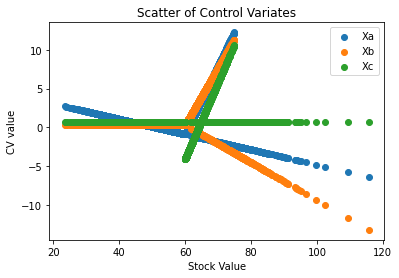

In [38]:
plt.scatter(Xa, Ylambdaa)
plt.scatter(Xa, Ylambdab)
plt.scatter(Xa, Ylambdac)
plt.title('Scatter of Control Variates')
plt.legend(['Xa', 'Xb', 'Xc'])
plt.xlabel("Stock Value")
plt.ylabel("CV value")
plt.show()

Notice how for Xb is more negative in the region of $S > 75$ which is the barrier limit, yet as we saw above its variance reduction factor was less. Xc meanwhile remains mostly flat, as it mimics the behavior of reporting zero when the barrier option payoff is zero.